In [53]:
pip install pandas


[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [54]:
pip install scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [55]:
pip install matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [56]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

In [60]:
# Function to calculate the required features for a SMILES string
def calculate_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    string_length = len(smiles)
    num_chiral_centers = len(Chem.FindMolChiralCenters(mol, includeUnassigned=False))
    mol_weight = Descriptors.MolWt(mol)
    num_heavy_atoms = mol.GetNumHeavyAtoms()
    return [string_length, num_chiral_centers, mol_weight, num_heavy_atoms]

# Read the SMILES strings from the file
with open("combined_nps(absolute coconut).txt", "r") as file:
    smiles_list = file.readlines()

# Remove any leading/trailing whitespace
smiles_list = [s.strip() for s in smiles_list]

# Calculate features for each SMILES string
data = []
for smiles in smiles_list:
    features = calculate_features(smiles)
    if features:
        data.append([smiles] + features)

# Convert to a DataFrame
columns = ["smiles", "string_length", "num_chiral_centers", "mol_weight", "num_heavy_atoms"]
df = pd.DataFrame(data, columns=columns)


df.head()


[12:00:00] WARNING: not removing hydrogen atom without neighbors


,smiles,string_length,num_chiral_centers,mol_weight,num_heavy_atoms
0,CC=C(N=CS)C(=O)OC1C(COC(C)=O)OC(C2(O)CC(=O)C(N...,87,0,660.651,45
1,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,78,0,598.604,44
2,COc1cc(C)cc2c1C(=O)O[C@@H]1[C@H](O)C=C[C@@H]3c...,100,5,598.604,44
3,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,73,0,554.551,41
4,COc1cc(C)cc2c1C(=O)O[C@@H]1[C@H](O)C=C[C@@H]3c...,95,5,554.551,41


In [70]:
# Aggregate bins for stratification
df['string_length_bin'] = pd.cut(df['string_length'], bins=10, labels=False)
df['num_chiral_centers_bin'] = pd.cut(df['num_chiral_centers'], bins=5, labels=False)
df['mol_weight_bin'] = pd.cut(df['mol_weight'], bins=10, labels=False)
df['num_heavy_atoms_bin'] = pd.cut(df['num_heavy_atoms'], bins=5, labels=False)

# Create a combined feature for stratification
df['stratify_col'] = (
    df['string_length_bin'].astype(str) + "_" +
    df['num_chiral_centers_bin'].astype(str) + "_" +
    df['mol_weight_bin'].astype(str) + "_" +
    df['num_heavy_atoms_bin'].astype(str)
)

# Ensure that each class has at least two members
while df['stratify_col'].value_counts().min() < 2:
    if df['string_length_bin'].nunique() > 1:
        df['string_length_bin'] = pd.cut(df['string_length'], bins=df['string_length_bin'].nunique() - 1, labels=False)
    if df['num_chiral_centers_bin'].nunique() > 1:
        df['num_chiral_centers_bin'] = pd.cut(df['num_chiral_centers'], bins=df['num_chiral_centers_bin'].nunique() - 1, labels=False)
    if df['mol_weight_bin'].nunique() > 1:
        df['mol_weight_bin'] = pd.cut(df['mol_weight'], bins=df['mol_weight_bin'].nunique() - 1, labels=False)
    if df['num_heavy_atoms_bin'].nunique() > 1:
        df['num_heavy_atoms_bin'] = pd.cut(df['num_heavy_atoms'], bins=df['num_heavy_atoms_bin'].nunique() - 1, labels=False)
    
    df['stratify_col'] = (
        df['string_length_bin'].astype(str) + "_" +
        df['num_chiral_centers_bin'].astype(str) + "_" +
        df['mol_weight_bin'].astype(str) + "_" +
        df['num_heavy_atoms_bin'].astype(str)
    )

# Perform stratified sampling for initial train/test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=114359, random_state=42)
train_index, test_index = next(sss.split(df, df['stratify_col']))

# Create train_df and test_df but keep 'stratify_col' and bin columns in train_df
train_df = df.iloc[train_index]
test_df = df.iloc[test_index].drop(columns=['stratify_col', 'string_length_bin', 'num_chiral_centers_bin', 'mol_weight_bin', 'num_heavy_atoms_bin'])

# Now apply StratifiedKFold to train_df to split further into chunks
train_chunks = []
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for train_index, test_index in skf.split(train_df, train_df['stratify_col']):
    chunk_df = train_df.iloc[test_index]
    train_chunks.append(chunk_df)

# Optionally, drop the no longer needed columns from train_df after the split
train_df = train_df.drop(columns=['stratify_col', 'string_length_bin', 'num_chiral_centers_bin', 'mol_weight_bin', 'num_heavy_atoms_bin'])

# Displaying the first few rows of train_df to confirm successful preprocessing
train_df.head()

# print and inspect each chunk
for idx, chunk in enumerate(train_chunks, start=1):
    print(f'Train Chunk {idx} Size:', len(chunk))
    display(chunk.head())

# Save train_df and test_df
train_df['smiles'].to_csv("./train.txt", index=False, header=False)
test_df['smiles'].to_csv("./test.txt", index=False, header=False)



Train Chunk 1 Size: 257309


,smiles,string_length,num_chiral_centers,mol_weight,num_heavy_atoms,string_length_bin,num_chiral_centers_bin,mol_weight_bin,num_heavy_atoms_bin,stratify_col
40516,CC(C(=O)NC1CC1)C1CCC2(C)Cc3sc(Nc4ccccc4)nc3C(C...,52,0,439.625,31,0,0,0,0,0_0_0_0
569935,CC/C=C/[C@H]1CCC[C@H](O)[C@@H](C)C(=O)C2=C[C@@...,144,14,602.765,43,0,0,0,0,0_0_0_0
438320,CN[C@@H]1Cc2c(cccc2CO)C#C[C@@]23CC[C@H](Cc4ccc...,266,26,1212.622,90,1,0,1,0,1_0_1_0
860444,COC1CC2(C)OC(=O)C3(COC(=O)c4ccccc4)C1CC23O[C@@...,83,5,494.493,35,0,0,0,0,0_0_0_0
706233,CC[C@]12C[N@]3C[C@@](CC)(C[N@](C1)[C@@H]3c1ccc...,61,0,318.417,23,0,0,0,0,0_0_0_0


Train Chunk 2 Size: 257309


,smiles,string_length,num_chiral_centers,mol_weight,num_heavy_atoms,string_length_bin,num_chiral_centers_bin,mol_weight_bin,num_heavy_atoms_bin,stratify_col
693816,CC(=O)O[C@H]1C(=O)[C@]2(C)[C@@H](O[C@@H]3OC[C@...,192,15,986.033,71,1,0,1,0,1_0_1_0
788675,C=C(/C=C\C[C@@H](O)[C@@H](O)[C@H](O)C/C=C/C=C\...,559,53,2635.133,183,3,0,2,0,3_0_2_0
115209,CC(=O)OC[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)C=C[C@...,100,8,480.645,35,0,0,0,0,0_0_0_0
409581,Nc1ncnc2c1ncn2[C@@H]1O[C@@H](CO)[C@@H](F)[C@@H]1O,49,4,269.236,19,0,0,0,0,0_0_0_0
621587,CNC(=N)N[C@@H]1CCC[C@H](O)[C@@]12C#C[C@H]1CCC[...,110,9,610.796,44,0,0,0,0,0_0_0_0


Train Chunk 3 Size: 257309


,smiles,string_length,num_chiral_centers,mol_weight,num_heavy_atoms,string_length_bin,num_chiral_centers_bin,mol_weight_bin,num_heavy_atoms_bin,stratify_col
1008375,COc1ccc2c(c1)OC(c1ccc(OC(C)=O)cc1)CC2/C=C/c1cc...,59,0,458.510,34,0,0,0,0,0_0_0_0
540485,CCC1CCC2(O)OC3CC(=O)C2(O)C1O3,29,0,228.244,16,0,0,0,0,0_0_0_0
193683,CC(C)NC(=O)N[C@@H]1CCN2C(=O)c3cc(-c4cccc(C(F)(...,70,2,460.456,33,0,0,0,0,0_0_0_0
1068411,CC[C@@]12CCCN3CCc4c(n(c5ccccc45)[C@@](O)(C(=O)...,59,3,354.450,26,0,0,0,0,0_0_0_0
857781,O=C(/C=C/c1ccc(O)c(O)c1)c1c(O)cc(O)cc1O[C@@H]1...,80,5,450.396,32,0,0,0,0,0_0_0_0


Train Chunk 4 Size: 257308


,smiles,string_length,num_chiral_centers,mol_weight,num_heavy_atoms,string_length_bin,num_chiral_centers_bin,mol_weight_bin,num_heavy_atoms_bin,stratify_col
152090,C=C1CC[C@@H]2[C@H]([C@H]3[C@H]1CC[C@]3(C)O)[C@...,64,6,304.474,22,0,0,0,0,0_0_0_0
660584,Cc1ccc(Nc2nc([C@@]3(C)C[C@]4(C[C@H](C)OC4=O)C(...,59,3,372.446,26,0,0,0,0,0_0_0_0
631117,CC=C1C(OC2OC(CO)C(O)C(O)C2O)OC=C2C(=O)OCCc3ccc...,77,0,628.627,45,0,0,0,0,0_0_0_0
28553,CC(=O)O[C@@H]1CC[C@]2(C)[C@H](CC[C@]3(C)[C@@H]...,122,10,623.919,45,0,0,0,0,0_0_0_0
772121,C=C(C)C1=CC[C@@H](C)[C@]12CC=C(C)CC2,36,2,202.341,15,0,0,0,0,0_0_0_0


In [71]:
test_df.head()

,smiles,string_length,num_chiral_centers,mol_weight,num_heavy_atoms
694398,Cc1c(O[C@H](C)C(=O)N2CC[C@]3(O)CCCC[C@H]3C2)cc...,66,3,425.525,31
970952,O=c1c2ccccc2nc2n1CC/C2=C/N1CCN(c2ccccc2)CC1,43,0,358.445,27
172166,CC#CC#CC=C(O)[C@@H](O)[C@H](O)[C@]1(O)CCCCO1,44,3,266.293,19
836695,COC(=O)CC[C@@H]1N=C(O)[C@H](Cc2ccccc2)N=C(O)[C...,278,14,1681.775,121
538091,COC(C)(C)[C@H]1CC[C@]2(C)C[C@@H]1C(=O)[C@@]1(C...,82,5,430.541,31


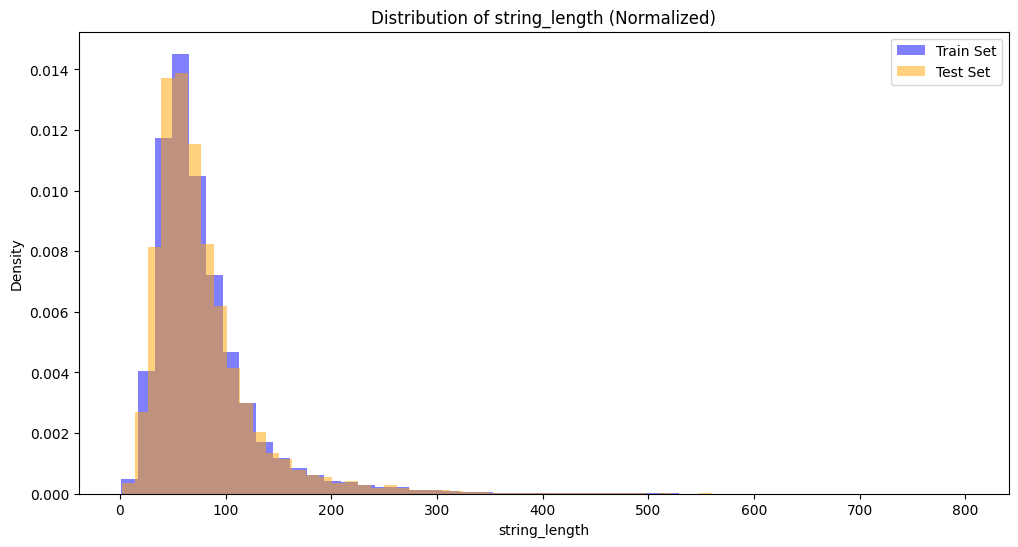

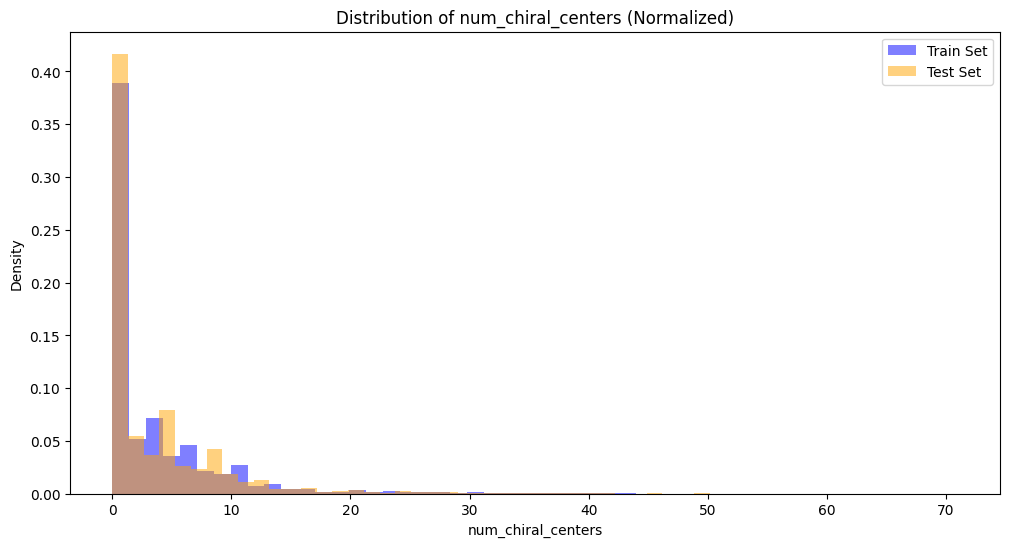

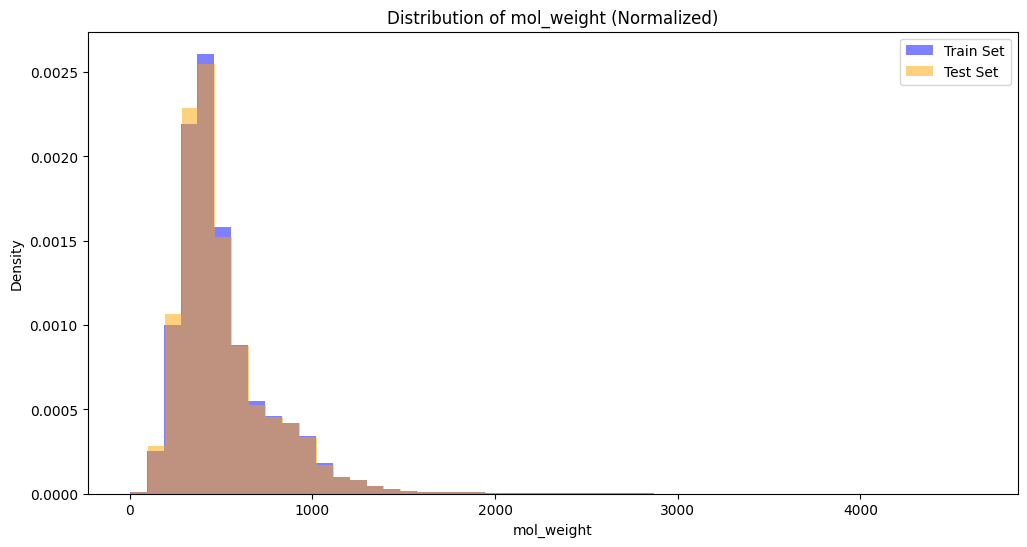

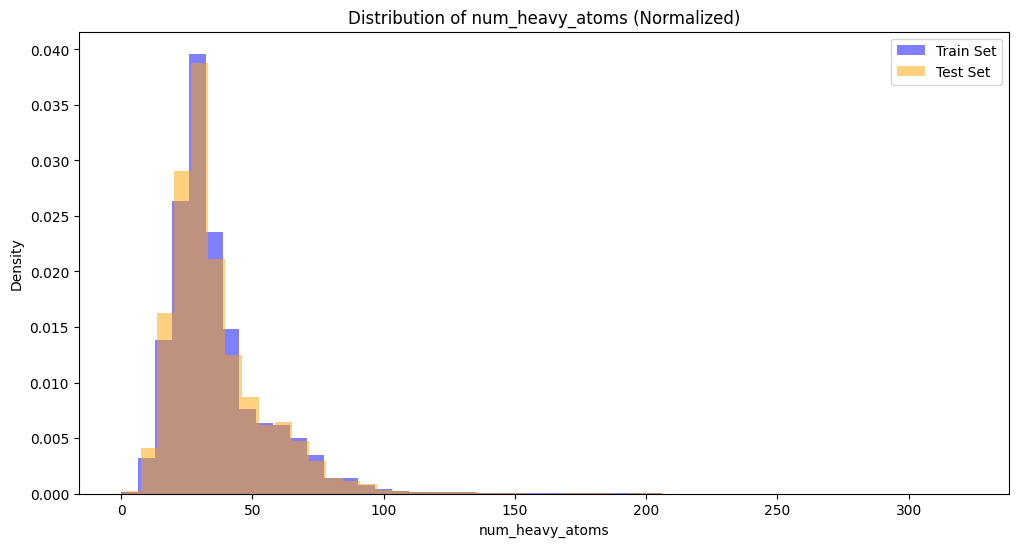

In [72]:
def plot_distribution(feature, train_df, test_df):
    plt.figure(figsize=(12, 6))
    plt.hist(train_df[feature], bins=50, alpha=0.5, label='Train Set', density=True, color='blue')
    plt.hist(test_df[feature], bins=50, alpha=0.5, label='Test Set', density=True, color='orange')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'Distribution of {feature} (Normalized)')
    plt.legend(loc='upper right')
    plt.show()

# Plot normalized distributions for all features
features = ["string_length", "num_chiral_centers", "mol_weight", "num_heavy_atoms"]
for feature in features:
    plot_distribution(feature, train_df, test_df)


In [74]:
print(len(train_df))

1029235


In [75]:
# Function to check for overlapping data points
def check_overlapping_data(train_df, test_df):
    overlapping_data = pd.merge(train_df, test_df, on='smiles', how='inner')
    return not overlapping_data.empty, overlapping_data

# Perform the check for overlapping data points
overlapping, overlapping_data_points = check_overlapping_data(train_df, test_df)

# Print the results for overlapping data points
print("Is there overlapping data:", overlapping)
if overlapping:
    print("Overlapping data points:")
    print(overlapping_data_points)

# Function to check for missing data points
def check_missing_data(original_df, train_df, test_df):
    combined_df = pd.concat([train_df, test_df])
    missing_data = original_df[~original_df['smiles'].isin(combined_df['smiles'])]
    return not missing_data.empty, missing_data

# Perform the check for missing data points
missing, missing_data_points = check_missing_data(df, train_df, test_df)

# Print the results for missing data points
print("Is there missing data:", missing)
if missing:
    print("Missing data points:")
    print(missing_data_points)

Is there overlapping data: False
Is there missing data: False


train25perc_1.head()
Length: 257309


,smiles,string_length,num_chiral_centers,mol_weight,num_heavy_atoms,string_length_bin,num_chiral_centers_bin,mol_weight_bin,num_heavy_atoms_bin,stratify_col
40516,CC(C(=O)NC1CC1)C1CCC2(C)Cc3sc(Nc4ccccc4)nc3C(C...,52,0,439.625,31,0,0,0,0,0_0_0_0
569935,CC/C=C/[C@H]1CCC[C@H](O)[C@@H](C)C(=O)C2=C[C@@...,144,14,602.765,43,0,0,0,0,0_0_0_0
438320,CN[C@@H]1Cc2c(cccc2CO)C#C[C@@]23CC[C@H](Cc4ccc...,266,26,1212.622,90,1,0,1,0,1_0_1_0
860444,COC1CC2(C)OC(=O)C3(COC(=O)c4ccccc4)C1CC23O[C@@...,83,5,494.493,35,0,0,0,0,0_0_0_0
706233,CC[C@]12C[N@]3C[C@@](CC)(C[N@](C1)[C@@H]3c1ccc...,61,0,318.417,23,0,0,0,0,0_0_0_0


train25perc_2.head()
Length: 257309


,smiles,string_length,num_chiral_centers,mol_weight,num_heavy_atoms,string_length_bin,num_chiral_centers_bin,mol_weight_bin,num_heavy_atoms_bin,stratify_col
693816,CC(=O)O[C@H]1C(=O)[C@]2(C)[C@@H](O[C@@H]3OC[C@...,192,15,986.033,71,1,0,1,0,1_0_1_0
788675,C=C(/C=C\C[C@@H](O)[C@@H](O)[C@H](O)C/C=C/C=C\...,559,53,2635.133,183,3,0,2,0,3_0_2_0
115209,CC(=O)OC[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)C=C[C@...,100,8,480.645,35,0,0,0,0,0_0_0_0
409581,Nc1ncnc2c1ncn2[C@@H]1O[C@@H](CO)[C@@H](F)[C@@H]1O,49,4,269.236,19,0,0,0,0,0_0_0_0
621587,CNC(=N)N[C@@H]1CCC[C@H](O)[C@@]12C#C[C@H]1CCC[...,110,9,610.796,44,0,0,0,0,0_0_0_0


train25perc_3.head()
Length: 257309


,smiles,string_length,num_chiral_centers,mol_weight,num_heavy_atoms,string_length_bin,num_chiral_centers_bin,mol_weight_bin,num_heavy_atoms_bin,stratify_col
1008375,COc1ccc2c(c1)OC(c1ccc(OC(C)=O)cc1)CC2/C=C/c1cc...,59,0,458.510,34,0,0,0,0,0_0_0_0
540485,CCC1CCC2(O)OC3CC(=O)C2(O)C1O3,29,0,228.244,16,0,0,0,0,0_0_0_0
193683,CC(C)NC(=O)N[C@@H]1CCN2C(=O)c3cc(-c4cccc(C(F)(...,70,2,460.456,33,0,0,0,0,0_0_0_0
1068411,CC[C@@]12CCCN3CCc4c(n(c5ccccc45)[C@@](O)(C(=O)...,59,3,354.450,26,0,0,0,0,0_0_0_0
857781,O=C(/C=C/c1ccc(O)c(O)c1)c1c(O)cc(O)cc1O[C@@H]1...,80,5,450.396,32,0,0,0,0,0_0_0_0


train25perc_4.head()
Length: 257308


,smiles,string_length,num_chiral_centers,mol_weight,num_heavy_atoms,string_length_bin,num_chiral_centers_bin,mol_weight_bin,num_heavy_atoms_bin,stratify_col
152090,C=C1CC[C@@H]2[C@H]([C@H]3[C@H]1CC[C@]3(C)O)[C@...,64,6,304.474,22,0,0,0,0,0_0_0_0
660584,Cc1ccc(Nc2nc([C@@]3(C)C[C@]4(C[C@H](C)OC4=O)C(...,59,3,372.446,26,0,0,0,0,0_0_0_0
631117,CC=C1C(OC2OC(CO)C(O)C(O)C2O)OC=C2C(=O)OCCc3ccc...,77,0,628.627,45,0,0,0,0,0_0_0_0
28553,CC(=O)O[C@@H]1CC[C@]2(C)[C@H](CC[C@]3(C)[C@@H]...,122,10,623.919,45,0,0,0,0,0_0_0_0
772121,C=C(C)C1=CC[C@@H](C)[C@]12CC=C(C)CC2,36,2,202.341,15,0,0,0,0,0_0_0_0


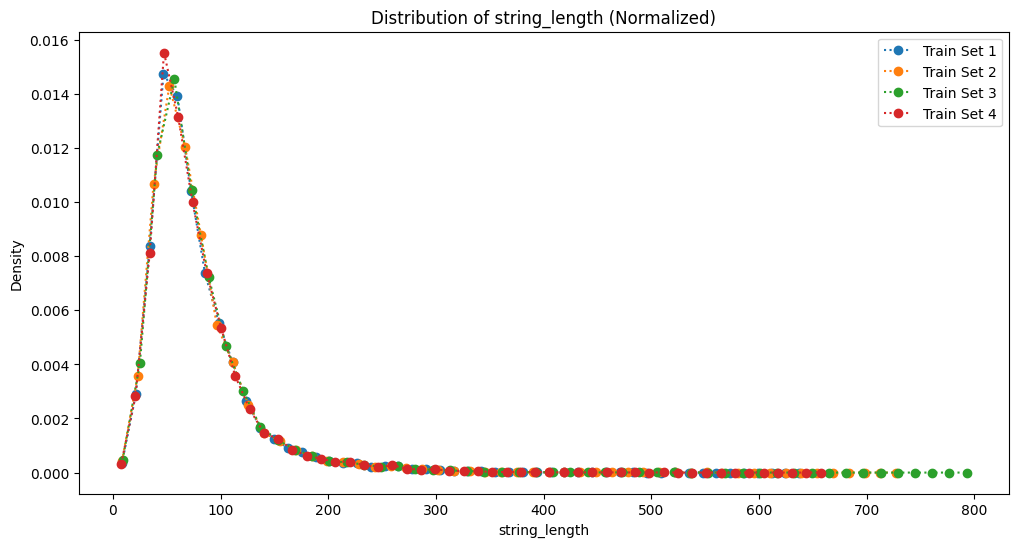

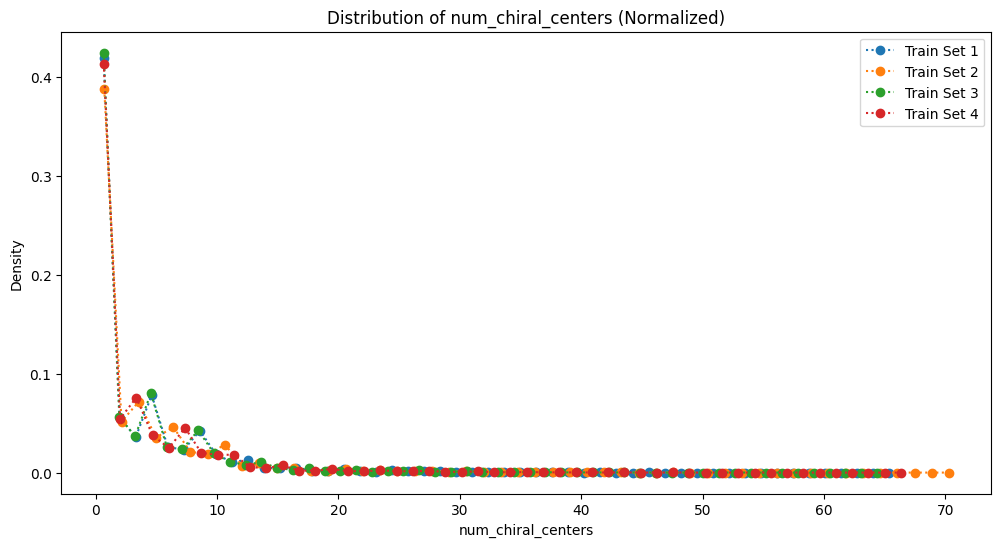

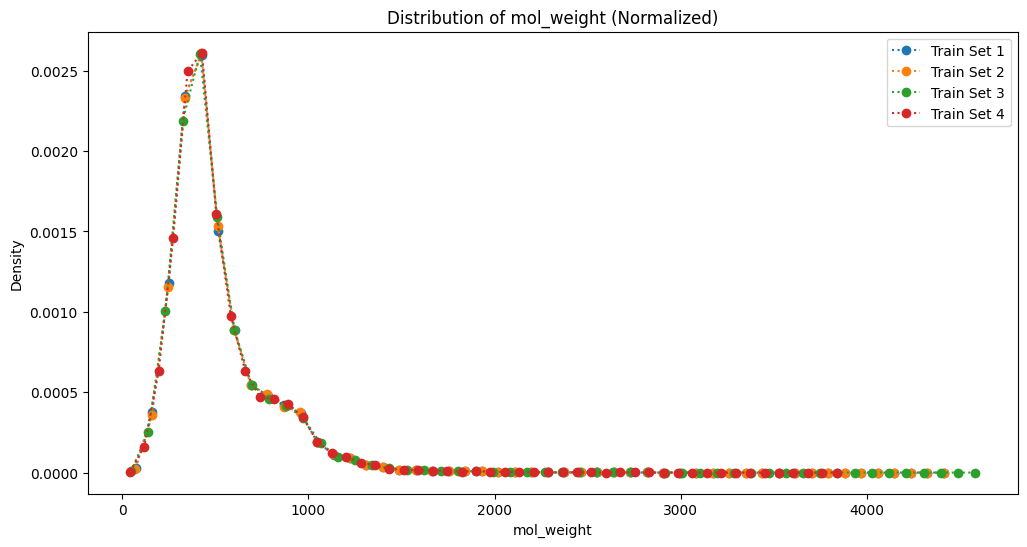

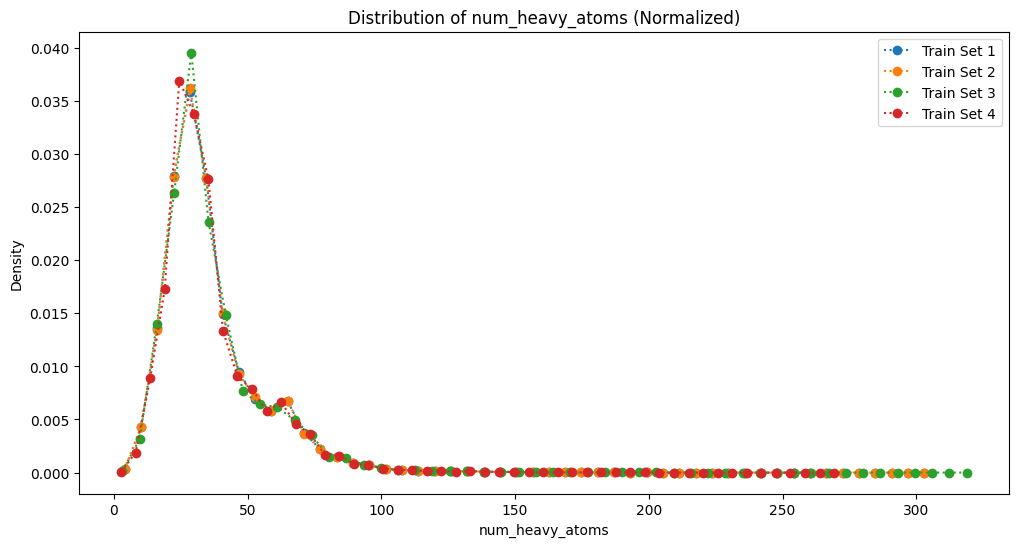

In [78]:
from sklearn.model_selection import StratifiedKFold

# Name the chunks
for idx, chunk in enumerate(train_chunks, start=1):
    globals()[f'train25perc_{idx}'] = chunk

# Check the first few rows of each chunk
for idx in range(1, 5):
    print(f"train25perc_{idx}.head()")
    print('Length:', len(globals()[f'train25perc_{idx}']))
    display(globals()[f'train25perc_{idx}'].head())


# Define the function to plot distributions as line plots
def plot_distribution_line(feature, train_chunks):
    plt.figure(figsize=(12, 6))
    for idx, chunk in enumerate(train_chunks, start=1):
        values, base = np.histogram(chunk[feature], bins=50, density=True)
        centers = (base[:-1] + base[1:]) / 2
        plt.plot(centers, values, linestyle='dotted', marker='o', label=f'Train Set {idx}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'Distribution of {feature} (Normalized)')
    plt.legend(loc='upper right')
    plt.show()

# Plot normalized distributions for all features as line plots
features = ["string_length", "num_chiral_centers", "mol_weight", "num_heavy_atoms"]
for feature in features:
    plot_distribution_line(feature, train_chunks)


In [80]:
# Check for overlapping data points
overlapping_data = False
all_data_points = set()

for idx, chunk in enumerate(train_chunks, start=1):
    current_data_points = set(chunk['smiles'])
    if not all_data_points.isdisjoint(current_data_points):
        overlapping_data = True
        break
    all_data_points.update(current_data_points)

print("Is there overlapping data:", overlapping_data)

# Check the combined number of data points in each subset
total_points_in_chunks = sum(len(chunk) for chunk in train_chunks)
print("Total points in all chunks:", total_points_in_chunks)

# Check the number of data points in the original dataset
original_data_points = len(df)
print("Total points in the original dataset:", original_data_points)




Is there overlapping data: False
Total points in all chunks: 1029235
Total points in the original dataset: 1143594


In [81]:
# Function to save each chunk to a text file containing only SMILES strings
def save_smiles_chunks(train_chunks, prefix="train25perc_"):
    for idx, chunk in enumerate(train_chunks, start=1):
        file_name = f"{prefix}{idx}.txt"
        chunk['smiles'].to_csv(file_name, index=False, header=False)
        print(f"Saved {file_name}")

# Save each chunk
save_smiles_chunks(train_chunks)


Saved train25perc_1.txt
Saved train25perc_2.txt
Saved train25perc_3.txt
Saved train25perc_4.txt
